# Modelo: Naive Bayes

https://scikit-learn.org/stable/modules/naive_bayes.html

Trabajaremos con el modelo de **Naive Bayes**, se conocen 3 diferentes formas de implementar: 
* Cuando trabajamos con features continuos -> (GaussianNB) 
* Cuando trabajamos con features discretos -> (MultinomialNB) 
* Cuando trabajamos con features categóricos -> (CategoricalNB)

Estaremos utilizando los 3 tipos de técnicas de Naive Bayes. Esto implica tener que dividir nuestro dataset de 3 formas distintas.

# Importación de librerias y datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import classification_report

Importamos diferentes funciones del preprocessing.py que utilizaremos y el dataset a trabajar

In [2]:
from preprocessing import obtener_datasets
from preprocessing import aplicar_preparacion
from preprocessing import conversion_numerica
from preprocessing import plot_roc_curves
from preprocessing import graficar_matriz_confusion

df, df_for_prediction = obtener_datasets()

# GaussianNB

In [3]:
from sklearn.naive_bayes import GaussianNB

Solo para valores continuos. Es decir nos quedaremos con las 2 columnas numéricas continuas de 'edad' y 'suma_declarada_bolsa_argentina'

In [4]:
df.describe()

,anios_estudiados,edad,ganancia_perdida_declarada_bolsa_argentina,horas_trabajo_registradas,tiene_alto_valor_adquisitivo
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,14.053868,38.581647,990.345014,40.437456,0.240810
std,2.664488,13.640433,7408.986951,12.347429,0.427581
min,1.000000,17.000000,-4356.000000,1.000000,0.000000
25%,13.000000,28.000000,0.000000,40.000000,0.000000
50%,14.000000,37.000000,0.000000,40.000000,0.000000
75%,16.000000,48.000000,0.000000,45.000000,0.000000
max,20.000000,90.000000,99999.000000,99.000000,1.000000


## Primer Preprocesamiento: obtener_features_continuas()

Empezamos primero importando la función creada en el preprocessing.py que nos da el dataset con las features continuas mencionadas

In [5]:
from preprocessing import obtener_features_continuas

Ademas aplicamos la preparación al dataset que ya venimos comentando en otros notebooks y luego aplicamos esta función importada para obtener las features consideradas como variables continuas.

In [6]:
df, df_for_prediction = obtener_datasets()
X_df, y_df = aplicar_preparacion(df)
X_df_c = obtener_features_continuas(X_df) 

### Entrenamiento

Entre hiperparametros importantes está el 'var_smoothing' es aquel factor que se le asigna cuando vienen eventos con probabilidades igual a 0 de elementos que nunca vio. Este hiperparámetro es el único que se tendrá en cuenta al utilizar GridSearchCV. Recordemos también que inicialmente haremos una partición del dataset de manera estratificada, además al utilizar cross-validation con GridSearch le estaremos indicando que haga folds estratificados con StatifiedKFold manteniendo las diferentes proporciones de la clase a predecir en cada fold.

Entrenemos con todo lo mencionado:

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_df_c, y_df, test_size=0.20, random_state=10, stratify=y_df)

params = {
        'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07],
}

clf = GaussianNB()
cv = StratifiedKFold(n_splits=10).split(X_train, y_train)
clf_1 = GridSearchCV(clf, params, scoring='roc_auc', cv=cv, n_jobs = -1, verbose=4)

clf_1.fit(X_train, y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    3.3s finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fff2ad352e0>,
             estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09,
                                           1e-08, 1e-07]},
             scoring='roc_auc', verbose=4)

### Métricas

Vamos a predecir ahora con X_test y mostrar diferentes métricas:

AUC-ROC score sobre test:  0.7608417722498504
AUC-ROC score sobre train:  0.7643356120777687
Accuracy sobre test:  0.7930293259634577
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
              precision    recall  f1-score   support

  Bajo valor       0.80      0.98      0.88      4945
  Alto valor       0.74      0.21      0.33      1568

    accuracy                           0.79      6513
   macro avg       0.77      0.60      0.61      6513
weighted avg       0.78      0.79      0.75      6513



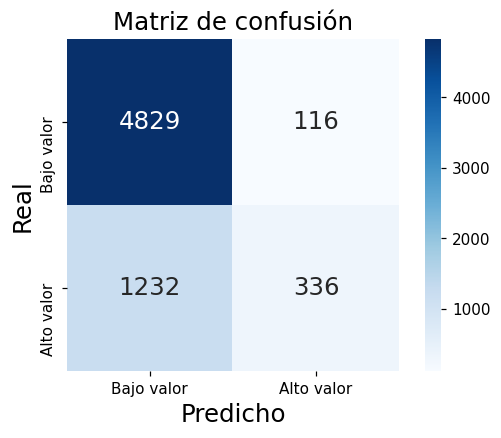

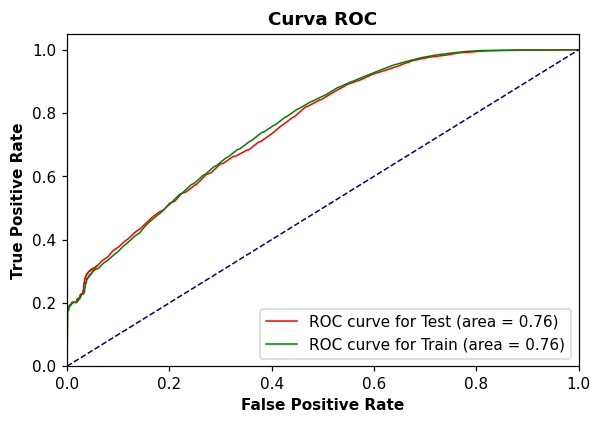

In [8]:
y_pred = clf_1.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf_1.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf_1.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_test, y_pred))
print("Los mejores hiperpametros elegidos: ", clf_1.best_params_)
print(classification_report(y_test, y_pred, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf_1, X_test, y_test, X_train, y_train)

Lo cual se puede observar que a pesar de haber solo utilizado 2 features, no fue un muy mal resultado. Es mejor que un modelo random.

Guardamos la predicción de probabilidad de cada clase para usarlo en un futuro ensamble gaussiano. Por ahora nos quedamos como mejor preprocesamiento a éste ultimo aplicado.

In [9]:
proba_gauss_train = clf_1.predict_proba(X_train)
proba_gauss_test = clf_1.predict_proba(X_test)

## Segundo Preprocesamiento: get_dataframe_scaled()

En este segundo preprocesamiento, utilizaremos 5 escalados guardados en un vector al cual aplicaremos con nuestra función get_dataframe_scaled(). Es decir GaussianNB entrenará 5 preprocesamientos distintos, uno por uno. Solamente consideraremos la métrica de AUC-ROC por tratarse de 5 escalados distintos. Importamos nuestra función y los 5 escalados: 

In [10]:
from preprocessing import get_dataframe_scaled
from sklearn.preprocessing import (
    MinMaxScaler,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    Normalizer
)

### Entrenamiento y AUC-ROC score

Entrenemos entonces el modelo con estos 5 preprocesamientos (escalados). Recordemos otra vez escalar después de dividir para evitar un posible data leak.

In [11]:
X_df_c = obtener_features_continuas(X_df) 
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler(), PowerTransformer(), Normalizer()]
for count, scaler in enumerate(scalers):
    print("---------------------------------------------------------------------")
    print("Aplicando preprocesamiento #",count+1, "con scaler de", scaler)
    X_train, X_test, y_train, y_test = train_test_split(X_df_c, y_df, test_size=0.20, random_state=10, stratify=y_df) 
    X_train = get_dataframe_scaled(X_train, scaler)
    X_test = get_dataframe_scaled(X_test, scaler)

    params =  {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}

    cv_e = StratifiedKFold(n_splits=10).split(X_train, y_train)
    clf = GridSearchCV(GaussianNB(), params, scoring='roc_auc', cv=cv_e, n_jobs = -1)
        
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(" AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
    print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
    print("Los mejores hiperpametros elegidos: ", clf.best_params_)  

---------------------------------------------------------------------
Aplicando preprocesamiento # 1 con scaler de StandardScaler()
 AUC-ROC score sobre test:  0.7613218619095766
AUC-ROC score sobre train:  0.7643349026782453
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
---------------------------------------------------------------------
Aplicando preprocesamiento # 2 con scaler de MinMaxScaler()
 AUC-ROC score sobre test:  0.7618572795650111
AUC-ROC score sobre train:  0.7643346366534238
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
---------------------------------------------------------------------
Aplicando preprocesamiento # 3 con scaler de RobustScaler()
 AUC-ROC score sobre test:  0.7593918950289923
AUC-ROC score sobre train:  0.7643356120777689
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
---------------------------------------------------------------------
Aplicando preprocesamiento # 4 con scaler de PowerTransformer()
 AUC-R

Se pudo observar que el escalado "PowerTransformer()" es superior al resto en cuanto el AUC-ROC ya demás superó al primer preprocesamiento realizado.

### Eligiendo al mejor: PowerTransformer()

Repliquemos la situación ya con el mejor hiperparámetro encontrado con este escalado:

    Los mejores hiperparámetros elegidos: {'var_smoothing': 1e-13} con el preprocesamiento PowerTransformer()

In [12]:
X_df_c = obtener_features_continuas(X_df) 

X_train, X_test, y_train, y_test = train_test_split(X_df_c, y_df, test_size=0.20, random_state=10, stratify=y_df)        
X_train = get_dataframe_scaled(X_train, PowerTransformer())
X_test = get_dataframe_scaled(X_test, PowerTransformer())

clf_2 = GaussianNB(var_smoothing=1e-13)
        
clf_2.fit(X_train, y_train)
y_pred = clf_2.predict(X_test)

print(" AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf_2.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf_2.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_test, y_pred))

 AUC-ROC score sobre test:  0.7648258393347227
AUC-ROC score sobre train:  0.7674680583795501
Accuracy sobre test:  0.7850452940273299


Veamos la matriz de confusión y diferentes métricas:

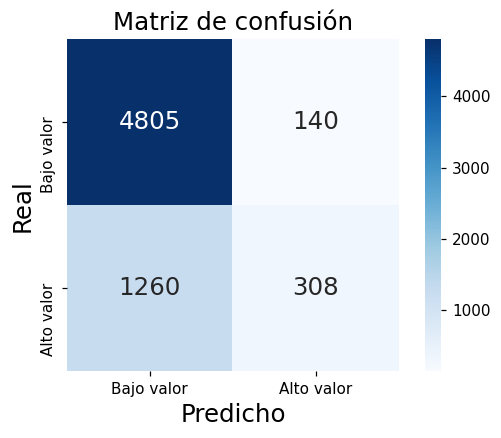

In [13]:
graficar_matriz_confusion(y_test, y_pred)

In [14]:
print(classification_report(y_test, y_pred, target_names=["Bajo valor", "Alto valor"]))

              precision    recall  f1-score   support

  Bajo valor       0.79      0.97      0.87      4945
  Alto valor       0.69      0.20      0.31      1568

    accuracy                           0.79      6513
   macro avg       0.74      0.58      0.59      6513
weighted avg       0.77      0.79      0.74      6513



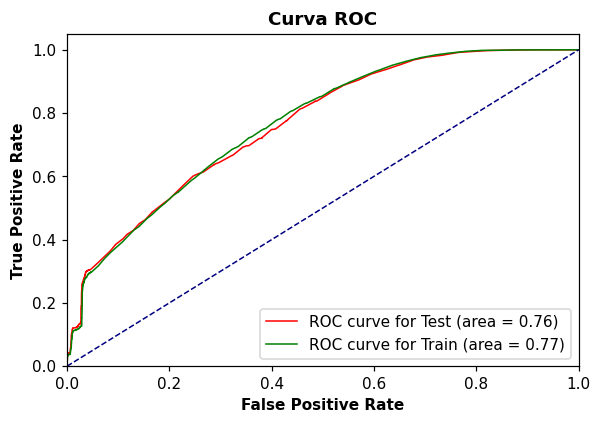

In [15]:
plot_roc_curves(clf_2, X_test, y_test, X_train, y_train)

Vemos que tiene graves problemas el recall de los altos valores como nos suele ocurrir con los diferentes modelos probados. Aún así nos quedaremos con éste como "mejor modelo" para utilizarlo después en un futuro ensamble:

In [16]:
proba_gauss_train = clf_2.predict_proba(X_train)
proba_gauss_test = clf_2.predict_proba(X_test)

# MultinomialNB

Solo para valores discretos.

In [17]:
from sklearn.naive_bayes import MultinomialNB

## Primer Preprocesamiento: obtener_features_discretas()

Algo similar como hicimos en el TP1 al discretizar la edad: importaremos nuestra función que discretizará todas nuestras features. A las categóricas las convierte a binarias tal como venia haciendo la "conversion_numerica" que veníamos trabajando en otros notebooks, pero en adición a esto, la función de "obtener_features_discretas" también discretiza la "suma_declarada_bolsa_argentina" con valores entre 0 a 8. Además de forma similar ocurrirá con las horas de trabajo registradas y la edad alcanzada. Es decir, dejamos como discreta-pura a la de años estudiados sin ser alterada.

Consideramos a esto mencionado como el *primer preprocesamiento* a aplicar:

In [18]:
from preprocessing import obtener_features_discretas
X_df_d_n = obtener_features_discretas(X_df)
X_df_d_n.describe()

Aplicando 'conversion_numerica' en las variables categóricas.


,edad,anios_estudiados,educacion_alcanzada,suma_declarada_bolsa_argentina,horas_trabajo_registradas,genero_mujer,estado_marital_matrimonio_civil,estado_marital_matrimonio_militar,estado_marital_pareja_no_presente,estado_marital_separado_a,...,categoria_de_trabajo_sin_trabajo,categoria_de_trabajo_trabajo_voluntariado,religion_budismo,religion_cristianismo,religion_judaismo,religion_otro,rol_familiar_registrado_con_hijos,rol_familiar_registrado_otro,rol_familiar_registrado_sin_familia,rol_familiar_registrado_soltero_a
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,...,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,2.494641,14.053868,4.204539,0.124597,2.035748,0.330795,0.459937,0.000706,0.012837,0.031479,...,0.000215,0.000430,0.031909,0.854274,0.095943,0.008323,0.155646,0.030128,0.255060,0.105832
std,1.925783,2.664488,0.956610,0.613312,0.821068,0.470506,0.498400,0.026569,0.112575,0.174612,...,0.014661,0.020731,0.175761,0.352837,0.294518,0.090851,0.362525,0.170942,0.435901,0.307627
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,13.000000,4.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,14.000000,4.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,16.000000,5.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,9.000000,20.000000,6.000000,7.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Entrenamiento

Dividíamos como veníamos haciendo con el GaussianNB recordando que es de manera estratificada tanto en el train_test_split y en GridSearchCV con StratifiedKFold.

Lo que tenemos en cuenta ahora con GridSearchCV es el hiperparametro de 'alpha' que actúa de forma similar al 'var_smoothing' (es decir,evitar eventos con probabilidad nulas) pero según entendemos en la bibliografía (https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) lo podemos ir probando entre 0 y 1. 

Entrenemos entonces:

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_df_d_n, y_df, test_size=0.20, random_state=10, stratify=y_df)

params = {
        'alpha': [0.0001, 0.001, 0.1, 0.3, 0.6, 0.9, 1],
}

clf = MultinomialNB()
cv = StratifiedKFold(n_splits=10).split(X_train, y_train)
clf_3 = GridSearchCV(clf, params, scoring='roc_auc', cv=cv, n_jobs = -1, verbose=4)

clf_3.fit(X_train, y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.7s finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7ffef10f9270>,
             estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.1, 0.3, 0.6, 0.9, 1]},
             scoring='roc_auc', verbose=4)

### Métricas

Veamos diferentes métricas y gráficos:

AUC-ROC score sobre test:  0.8650272255009184
AUC-ROC score sobre train:  0.8678716381868958
Accuracy sobre test:  0.7990173499155535
Los mejores hiperpametros elegidos:  {'alpha': 0.3}
              precision    recall  f1-score   support

  Bajo valor       0.90      0.83      0.86      4945
  Alto valor       0.57      0.69      0.62      1568

    accuracy                           0.80      6513
   macro avg       0.73      0.76      0.74      6513
weighted avg       0.82      0.80      0.81      6513



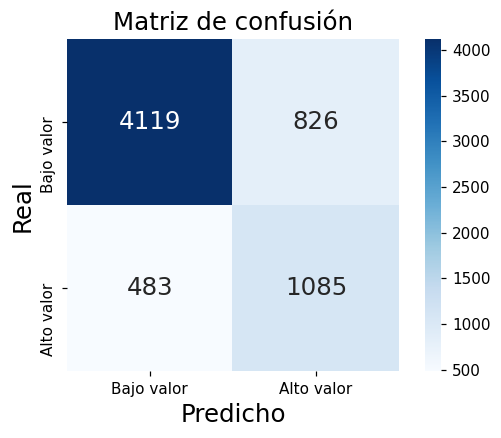

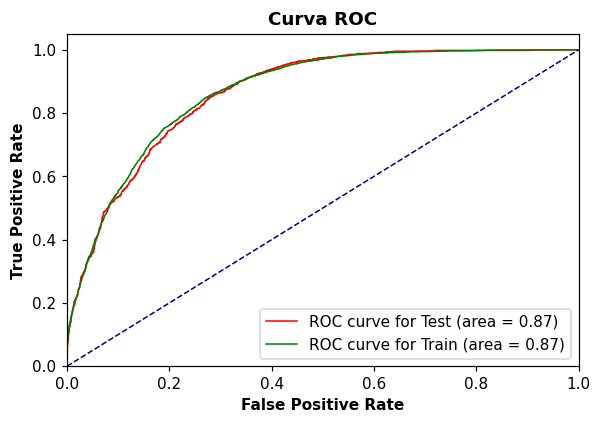

In [20]:
y_pred = clf_3.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf_3.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf_3.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_test, y_pred))
print("Los mejores hiperpametros elegidos: ", clf_3.best_params_)
print(classification_report(y_test, y_pred, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf_3, X_test, y_test, X_train, y_train)


La verdad, un buen modelo en general con tan solo ver la diagonal de la matriz de confusión. El AUC-ROC también se ve una buena mejora en comparación al modelo GaussianoNB. Mantendremos a este como el mejor modelo para un futuro ensamble gaussiano:

In [21]:
proba_multi_train = clf_3.predict_proba(X_train)
proba_multi_test = clf_3.predict_proba(X_test)

Probemos un segundo preprocesamiento:

## Segundo Preprocesamiento: Scalers

En este segundo preprocesamiento probaremos solamente 2 escalados: MinMaxScaler() y Normalizer() con nuestra función get_dataframe_scaled(), pues los demás preprocesamientos nos dan valores negativos y MultinomialNB solo trata con valores discretos mayores a cero. Veamos si esto mejora un poco el anterior resultado.

In [22]:
scalers = [MinMaxScaler(), Normalizer()]
X_df_d = obtener_features_discretas(X_df)

for count, scaler in enumerate(scalers):
    print("---------------------------------------------------------------------")
    print("Aplicando preprocesamiento #",count+1, "con scaler de", scaler)
    X_train, X_test, y_train, y_test = train_test_split(X_df_d, y_df, test_size=0.20, random_state=10, stratify=y_df)        
    X_train = get_dataframe_scaled(X_train, scaler)
    X_test = get_dataframe_scaled(X_test, scaler)
    
    params = {
            'alpha': [0.0001, 0.001, 0.1, 0.3, 0.6, 0.9, 1],
    }
    cv_e = StratifiedKFold(n_splits=10).split(X_train, y_train)
    clf = GridSearchCV(MultinomialNB(), params, scoring='roc_auc', cv=cv_e, n_jobs = -1)
        
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(" AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
    print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
    print("Los mejores hiperpametros elegidos: ", clf.best_params_)

Aplicando 'conversion_numerica' en las variables categóricas.
---------------------------------------------------------------------
Aplicando preprocesamiento # 1 con scaler de MinMaxScaler()
 AUC-ROC score sobre test:  0.8563973478673572
AUC-ROC score sobre train:  0.8596401611223669
Los mejores hiperpametros elegidos:  {'alpha': 0.1}
---------------------------------------------------------------------
Aplicando preprocesamiento # 2 con scaler de Normalizer()
 AUC-ROC score sobre test:  0.8545626251005963
AUC-ROC score sobre train:  0.8590594611828472
Los mejores hiperpametros elegidos:  {'alpha': 0.001}


Empeoró rotundamente ambos preprocesamiento con escalados la métrica de AUC-ROC sobre test.
Nos quedaremos entonces con el primer preprocesamiento simple.

# CategorialNB

## Primer Preprocesameitno: conversion_numerica()

Este método de NB considera solo las variables categóricas, nosotros teníamos 

In [23]:
len(df.columns) - len(df.describe().columns)

7

Un total de 7 variables categóricas. Según la bibliografía (https://scikit-learn.org/stable/modules/naive_bayes.html#categorical-naive-bayes) recomienda que el frame **X** que usaremos para entrenar esté encodeado. Seguiremos manteniendo la esencia de convertir a binaria aquellas variables categóricas que no representan un valor de orden, y luego con orden a las que sí (la educación alcanzada por ejemplo).

In [24]:
X_df_cat = conversion_numerica(X_df[['categoria_de_trabajo', 'educacion_alcanzada', 'estado_marital', 'genero', 'religion', 'rol_familiar_registrado', 'trabajo']])
X_df_cat.shape

Aplicando 'conversion_numerica' en las variables categóricas.


(32561, 36)

Quedándonos así 36 features encodeadas, provenientes de variables categóricas. 

### Entrenamiento

Apliquemos otra vez como venimos haciendo la división en train y test, luego GridSearchCV con StratifiedKFold y entrenemos.

Tanto CategorialNB como MultinomialNB consideraremos como hiperparámetro importante al mismo 'alpha'

In [25]:
from sklearn.naive_bayes import CategoricalNB

X_train, X_test, y_train, y_test = train_test_split(X_df_cat, y_df, test_size=0.20, random_state=10, stratify=y_df)

params = {
        'alpha': [0.0001, 0.001, 0.1, 0.3, 0.6, 0.9, 1],
}

clf = CategoricalNB()
cv = StratifiedKFold(n_splits=20).split(X_train, y_train)
clf_4 = GridSearchCV(clf, params, scoring='roc_auc', cv=cv, n_jobs = -1, verbose=4)

clf_4.fit(X_train, y_train)

Fitting 20 folds for each of 7 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 133 out of 140 | elapsed:    2.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    2.2s finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7ffef12047b0>,
             estimator=CategoricalNB(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.1, 0.3, 0.6, 0.9, 1]},
             scoring='roc_auc', verbose=4)

### Métricas

Vamos a predecir y mostrar algunas métricas:

AUC-ROC score sobre test:  0.8602924903530673
AUC-ROC score sobre train:  0.8630706398682936
Accuracy sobre test:  0.7813603562106556
Los mejores hiperpametros elegidos:  {'alpha': 0.1}
              precision    recall  f1-score   support

  Bajo valor       0.91      0.79      0.85      4945
  Alto valor       0.53      0.75      0.62      1568

    accuracy                           0.78      6513
   macro avg       0.72      0.77      0.73      6513
weighted avg       0.82      0.78      0.79      6513



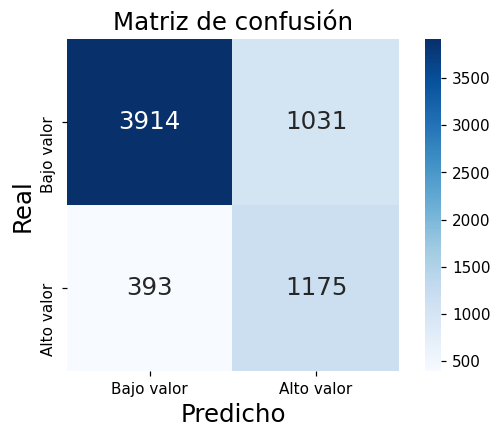

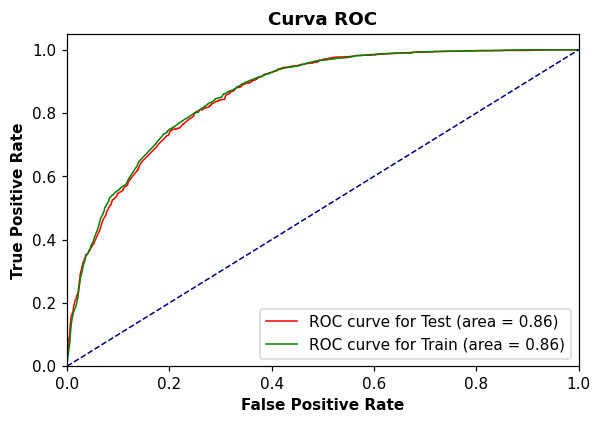

In [26]:
y_pred = clf_4.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf_4.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf_4.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_test, y_pred))
print("Los mejores hiperpametros elegidos: ", clf_4.best_params_)
print(classification_report(y_test, y_pred, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf_4, X_test, y_test, X_train, y_train)

Un modelo bastante bueno otra vez con buen AUC-ROC

Guardemos entonces las probabilidades de este modelo como las mejores por ahora:

In [27]:
proba_catego_train = clf_4.predict_proba(X_train)
proba_catego_test = clf_4.predict_proba(X_test)

## Segundo Preprocesamietno: conversion_numerica_generalizada()

Aplicaremos un segundo preprocesamiento donde se incluye una generalización de features, agregando la categoría de barrios indicando si se pertenece a Palermo o no, como también ahora la educación alcanzada se vuelve mas general tomando cada nivel alcanzado. Importemos y apliquemos entonces esta función:

In [28]:
from preprocessing import aplicar_preparacion_generalizado
from preprocessing import conversion_numerica_generalizada

In [29]:
df_, df_for_prediction = obtener_datasets()
X_df, y_df = aplicar_preparacion_generalizado(df_)

In [30]:
X_df_cat = conversion_numerica_generalizada(X_df[['barrio','categoria_de_trabajo', 'educacion_alcanzada', 'estado_marital', 'genero', 'religion', 'rol_familiar_registrado', 'trabajo']])
X_df_cat.shape

Aplicando 'conversion_numerica_generalizada' en las variables categóricas.


(32561, 39)

### Entrenamiento

In [31]:
from sklearn.naive_bayes import CategoricalNB

X_train, X_test, y_train, y_test = train_test_split(X_df_cat, y_df, test_size=0.20, random_state=10, stratify=y_df)

params = {
        'alpha': [0.0001, 0.001, 0.1, 0.3, 0.6, 0.9, 1],
}


clf = CategoricalNB()
cv = StratifiedKFold(n_splits=20).split(X_train, y_train)
clf_5 = GridSearchCV(clf, params, scoring='roc_auc', cv=cv, n_jobs = -1, verbose=4)

clf_5.fit(X_train, y_train)

Fitting 20 folds for each of 7 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    2.6s finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7ffef03e9120>,
             estimator=CategoricalNB(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.1, 0.3, 0.6, 0.9, 1]},
             scoring='roc_auc', verbose=4)

### Métricas

AUC-ROC score sobre test:  0.8628155243391593
AUC-ROC score sobre train:  0.8653079771371819
Accuracy sobre test:  0.7799785045294028
Los mejores hiperpametros elegidos:  {'alpha': 0.001}
              precision    recall  f1-score   support

  Bajo valor       0.91      0.79      0.85      4945
  Alto valor       0.53      0.75      0.62      1568

    accuracy                           0.78      6513
   macro avg       0.72      0.77      0.73      6513
weighted avg       0.82      0.78      0.79      6513



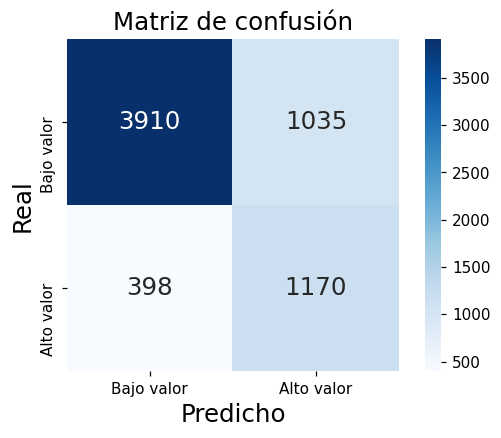

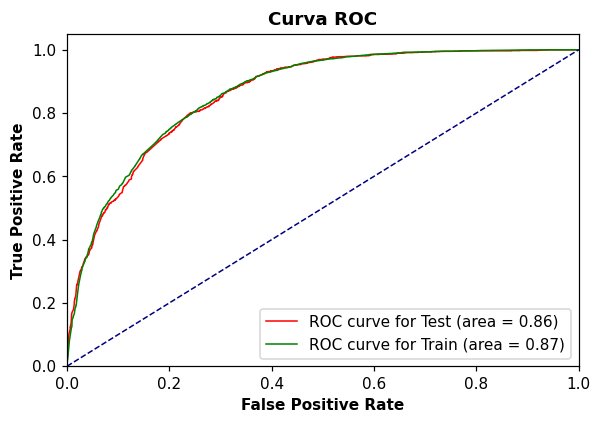

In [32]:
y_pred = clf_5.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf_5.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf_5.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_test, y_pred))
print("Los mejores hiperpametros elegidos: ", clf_5.best_params_)
print(classification_report(y_test, y_pred, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf_5, X_test, y_test, X_train, y_train)

Vemos una mejora respecto al AUC-ROC anterior. Nos quedaremos entonces este como mejor modelo para usar en el ensamble.

In [33]:
proba_catego_train = clf_5.predict_proba(X_train)
proba_catego_test = clf_5.predict_proba(X_test)

# Aplicando ensamble Gaussiano

Teniendo en cuenta lo visto en la clase práctica de la materia:

    "...en sklearn no tiene la funcionalidad de trabajar al mismo tiempo con variables categóricas y variables continuas. Se podría hacer un ensamble agarramos las probabilidades de GaussianNB, MultinomialNB y CategoricalNB y le metemos un GaussianNB al final juntando lo que devuelven los anteriores"

Nos guiaremos ademas en la idea de utiliza las funciones de np.hstack tal como lo mencionado en la siguiente fuente: 

https://stackoverflow.com/questions/14254203/mixing-categorial-and-continuous-data-in-naive-bayes-classifier-using-scikit-lea

In [34]:
X_train_assemble = np.hstack((proba_gauss_train, proba_multi_train, proba_catego_train))
X_test_assemble = np.hstack((proba_gauss_test, proba_multi_test, proba_catego_test))

Podríamos intentar unir este *X_train* y *X_test* de la siguiente forma: 

X_df_new = pd.DataFrame(np.vstack((X_train_assemble, X_test_assemble)))

Para después agarrar train_test_split() y dividir (otra vez) en train y test.

Pero no seria lo correcto por que estamos **asumiendo** que la división realizada por **train_test_split()** haya sido **consecutiva**.

In [35]:
X_train_assemble.shape

(26048, 6)

In [36]:
X_test_assemble.shape

(6513, 6)

Es decir, asumiríamos que agarró los 26048 elementos primero, y luego 6513 siguientes: eso no realiza *train_test_split* pues, la misma lo divide teniendo en cuenta un factor random (lo cual al indicar el random_state=10 mantenemos siempre el mismo split) y ademas tiene en cuenta la división con respecto a la proporción de la clase (stratify) a predecir como veníamos aplicando en diferentes splits.

Al aplicar ese *np.vstack* asumimos que esto no haya pasado y por consiguiente el modelo nos podría dar cualquier cosa.

Veamoslo:

Fitting 20 folds for each of 7 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.9s finished
/home/feduntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC-ROC score sobre test:  0.4884594699861745
AUC-ROC score sobre train:  0.5066819187564227
Accuracy sobre test:  0.7592507293106096
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
              precision    recall  f1-score   support

  Bajo valor       0.76      1.00      0.86      4945
  Alto valor       0.00      0.00      0.00      1568

    accuracy                           0.76      6513
   macro avg       0.38      0.50      0.43      6513
weighted avg       0.58      0.76      0.66      6513



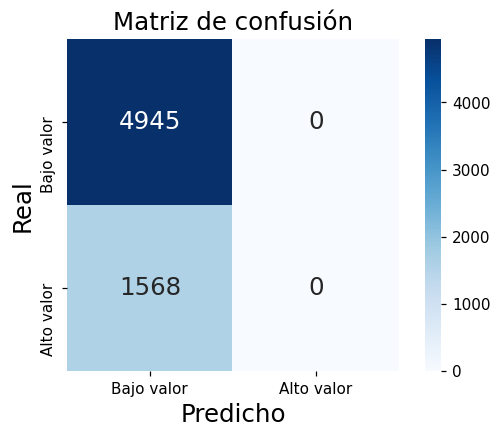

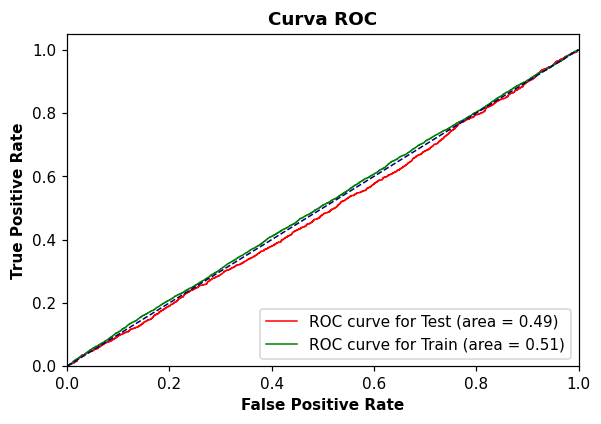

In [37]:
X_df_new = pd.DataFrame(np.vstack((X_test_assemble, X_train_assemble)))
X_train, X_test, y_train, y_test = train_test_split(X_df_new, y_df, test_size=0.20, random_state=0, stratify=y_df)

params = {
        'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07],
}

clf = GaussianNB()
cv = StratifiedKFold(n_splits=20).split(X_train, y_train)
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv, n_jobs = -1, verbose=4)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_test, y_pred))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(y_test, y_pred, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf, X_test, y_test, X_train, y_train)


Es decir, nos dió incluso peor que un modelo RANDOM.

## Primer Preprocesamiento directo

### Entrenamiento

Para esto, entonces hagamos un split con 'train_test_split' tal como veníamos haciendo en cada calculo de probabilidad de clase realizado con los distintos modelos. Mantenemos el mismo random_state pero solamente usaremos el *y_test* e *y_train* que nos dará el split, pues el *X_train* como *X_test* serán el del ensamble. 

In [38]:
X_train_s, X_test_s, y_train, y_test = train_test_split(X_df, y_df, test_size=0.20, random_state=10, stratify=y_df)
X_train, X_test = X_train_assemble, X_test_assemble

params = {
        'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07],
}

clf = GaussianNB()
cv = StratifiedKFold(n_splits=20).split(X_train, y_train)
clf_6 = GridSearchCV(clf, params, scoring='roc_auc', cv=cv, n_jobs = -1, verbose=4)

clf_6.fit(X_train, y_train)

Fitting 20 folds for each of 7 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.3s finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7ffef036c660>,
             estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09,
                                           1e-08, 1e-07]},
             scoring='roc_auc', verbose=4)

### Métricas

AUC-ROC score sobre test:  0.8705184968325046
AUC-ROC score sobre train:  0.8725916319474045
Accuracy sobre test:  0.7967142637801320
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
              precision    recall  f1-score   support

  Bajo valor       0.91      0.81      0.86      4945
  Alto valor       0.56      0.75      0.64      1568

    accuracy                           0.80      6513
   macro avg       0.73      0.78      0.75      6513
weighted avg       0.83      0.80      0.81      6513



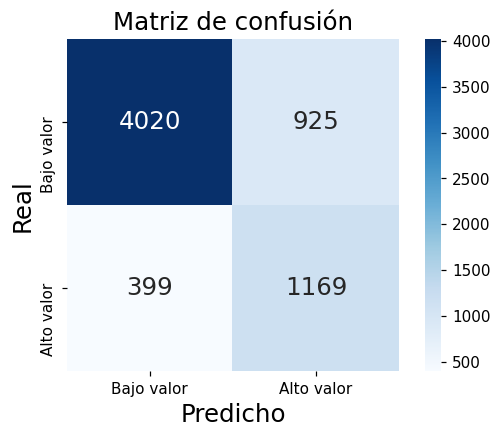

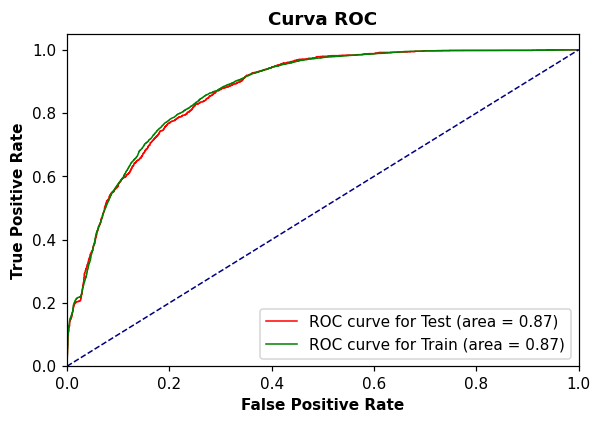

In [39]:
y_pred = clf_6.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf_6.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf_6.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_test, y_pred))
print("Los mejores hiperpametros elegidos: ", clf_6.best_params_)
print(classification_report(y_test, y_pred, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf_6, X_test, y_test, X_train, y_train)

Lo cual se puede observar una mejora increíble con un ensamble en comparación a haber trabajo individualmente cada modelo.

## Segundo Preprocesamiento: get_dataframe_polynomial_all()

Para este caso, buscaremos realizar una expansión del dataset mediante PolynomialFeatures. Ésto solo se aplicará para TODAS las features de nuestro dataset. En este caso al trabajar con un ensamble haremos uso de la función del preprocessing.py que aplica PolynomialFeature a todas las features.

In [40]:
from preprocessing import get_dataframe_polynomial_all

### Grado 2, interaction_only = true

* **Grado 2, True**: veamos primero con una expansión de grado 2 con interaction_only=True para las potencias:

In [41]:
X_train_ensamble, X_test_ensamble = pd.DataFrame(X_train_assemble), pd.DataFrame(X_test_assemble)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.20, random_state=10, stratify=y_df)               
X_train = get_dataframe_polynomial_all(X_train_ensamble, 2, True)
X_test = get_dataframe_polynomial_all(X_test_ensamble, 2, True)

params = {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
cv_e = StratifiedKFold(n_splits=10).split(X_train, y_train)
clf_7 = GridSearchCV(GaussianNB(), params, scoring='roc_auc', cv=cv_e, n_jobs = -1)
        
clf_7.fit(X_train, y_train)
y_pred = clf_7.predict(X_test)

print(" AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf_7.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf_7.predict_proba(X_train)[:, 1]))
print("Los mejores hiperpametros elegidos: ", clf_7.best_params_)

Dataset inicial con 6 features...
Dataset nuevo con PolynomialFeature con 21 features...
Dataset inicial con 6 features...
Dataset nuevo con PolynomialFeature con 21 features...
 AUC-ROC score sobre test:  0.8772469743711439
AUC-ROC score sobre train:  0.8796718341988208
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}


### Grado 2, interaction_only = false

* **Grado 2, False**: lo mismo con intercation_only = False

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.20, random_state=10, stratify=y_df)               
X_train = get_dataframe_polynomial_all(X_train_ensamble, 2, False)
X_test = get_dataframe_polynomial_all(X_test_ensamble, 2, False)

params = {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
cv_e = StratifiedKFold(n_splits=10).split(X_train, y_train)
clf_8 = GridSearchCV(GaussianNB(), params, scoring='roc_auc', cv=cv_e, n_jobs = -1)
        
clf_8.fit(X_train, y_train)
y_pred = clf_8.predict(X_test)

print(" AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf_8.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf_8.predict_proba(X_train)[:, 1]))
print("Los mejores hiperpametros elegidos: ", clf_8.best_params_)

Dataset inicial con 6 features...
Dataset nuevo con PolynomialFeature con 27 features...
Dataset inicial con 6 features...
Dataset nuevo con PolynomialFeature con 27 features...
 AUC-ROC score sobre test:  0.8751515393821838
AUC-ROC score sobre train:  0.8771551748982203
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}


### Eligiendo al mejor

Entonces como mejor preprocesamiento realizado al ensamble gaussiano es aquel donde expandimos con PolynomialFeatures con grado 2 e intercation_only=True para las potencias con un 'var_smoothing' de 1e-13.

Presentaremos este como mejor modelo para el ensamble. Entrenemos dicho modelo para ver sus métricas después.

#### Entrenamiento

In [44]:
X_train_s, X_test, y_train_s, y_test = train_test_split(X_df, y_df, test_size=0.20, random_state=10, stratify=y_df)        
X_train, X_test = pd.DataFrame(X_train_assemble), pd.DataFrame(X_test_assemble)
X_train = get_dataframe_polynomial_all(X_train, 2, False)
X_test = get_dataframe_polynomial_all(X_test, 2, False)

clf_9 = GaussianNB(var_smoothing = 1e-13)

clf_9.fit(X_train, y_train)

Dataset inicial con 6 features...
Dataset nuevo con PolynomialFeature con 27 features...
Dataset inicial con 6 features...
Dataset nuevo con PolynomialFeature con 27 features...


GaussianNB(var_smoothing=1e-13)

#### Métricas

Veamos diferentes métricas para el mismo al predecir

 AUC-ROC score sobre test:  0.8751515393821838
AUC-ROC score sobre train:  0.8771551748982203
Accuracy sobre test:  0.7798249654537079
              precision    recall  f1-score   support

  Bajo valor       0.92      0.77      0.84      4945
  Alto valor       0.53      0.80      0.64      1568

    accuracy                           0.78      6513
   macro avg       0.73      0.79      0.74      6513
weighted avg       0.83      0.78      0.79      6513



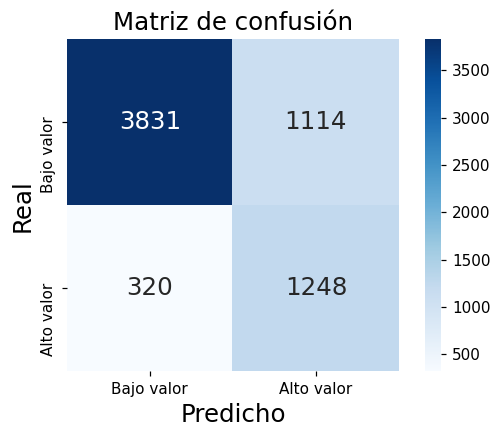

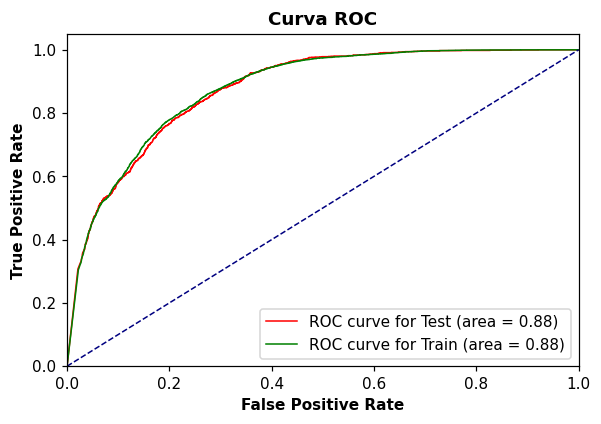

In [45]:
y_pred = clf_9.predict(X_test)


print(" AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf_9.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf_9.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf_9, X_test, y_test, X_train, y_train)

Un buen ensamble si miramos la diagonal. El AUC-ROC fue el máximo ahsta ahora que resultó 0.88 sobre Test.

# Predicciones holdout

Habíamos visto que el mejor resultado para NaiveBayes fue con el ensamble combinando los 3 tipos de NaiveBayes, todo terminaría aplicándole un preprocesamiento con la expansión polynomial de grado 2 e intercation_only = false.

Importamos y apliquemos la función necesaria para aplicar la preparación en el set de holdout. Recordemos que esta función aplica internamente la función de '**aplicar_preparacion()**' o '**aplicar_preparacion_generalizado()**' según el booleano recibido.

In [46]:
from preprocessing import aplicar_preparacion_holdout

X_holdout = aplicar_preparacion_holdout(df_for_prediction, generalizada=False)

Apliquemos el procesado con el que obtuvimos el mejor score AUC-ROC. 

Pero primero ataquemos las features continuas del dataset holdout. Utilicemos dicho clasificador conseguido y guardado en la variable **clf_2** para así predecir la probabilidad de cada clase:

In [47]:
X_holdout_numerico_g = obtener_features_continuas(X_holdout) 
X_holdout_numerico_g = get_dataframe_scaled(X_holdout_numerico_g, PowerTransformer())
X_holdout_numerico_g_proba = clf_2.predict_proba(X_holdout_numerico_g)

Luego sigue el turno de las features discretas:

In [48]:
X_holdout_numerico_d = obtener_features_discretas(X_holdout) 
X_holdout_numerico_d_proba = clf_3.predict_proba(X_holdout_numerico_d)

Aplicando 'conversion_numerica' en las variables categóricas.


Y por ultimo de las features categóricas que se trabjo de forma generalizada a la preparación, aprovechamos el booleano y le indicamos True.

In [49]:
X_holdout_generalizada = aplicar_preparacion_holdout(df_for_prediction, generalizada=True)
X_holdout_generalizada_c = conversion_numerica_generalizada(X_holdout_generalizada[['barrio','categoria_de_trabajo', 'educacion_alcanzada', 'estado_marital', 'genero', 'religion', 'rol_familiar_registrado', 'trabajo']])

X_holdout_numerico_c_proba = clf_5.predict_proba(X_holdout_generalizada_c)

Aplicando 'conversion_numerica_generalizada' en las variables categóricas.


Todo esto fue con el respectivo mejor procesado y clasificador encontrado en su análisis. Ahora unamos las probas conseguidas y apliquemos a ese nuevo frame conseguido el mejor procesado y clasificador encontrado con el **clf_9**:

In [50]:
X_frame = pd.DataFrame(np.hstack((X_holdout_numerico_g_proba, X_holdout_numerico_d_proba, X_holdout_numerico_c_proba)))

In [51]:
X_frame_holdout = get_dataframe_polynomial_all(X_frame, 2, False)

Dataset inicial con 6 features...
Dataset nuevo con PolynomialFeature con 27 features...


Hagamos **.predict()** sobre este holdout para luego agregarlo como nueva columna en este dataset para así exportar el **.csv** con facilidad mediante Pandas. 

In [52]:
y_pred_holdout = clf_9.predict(X_frame_holdout)
X_holdout['tiene_alto_valor_adquisitivo'] = y_pred_holdout

In [53]:
name_model = '#3 - Naive Bayes'

if X_holdout.index[0] == 0:
    X_holdout.index += 1 
X_holdout['tiene_alto_valor_adquisitivo'].to_csv('predicciones/' + name_model + '.csv', index=True, index_label = 'id')